In [16]:
# Step 1 — Load dataset & inspect age distribution

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Load the TidyTuesday single-response dataset (Stack Overflow 2024)
URL = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2024/2024-09-03/stackoverflow_survey_single_response.csv"
df = pd.read_csv(URL, low_memory=False)
print("Shape:", df.shape)


Shape: (65437, 28)


In [17]:
# Quick look at the first few rows
display(df.head(3))

# Count missing values by column
missing = (
    df.isna().sum()
      .sort_values(ascending=False)
      .to_frame("missing_count")
      .assign(missing_pct=lambda t: (t["missing_count"]/len(df)*100).round(2))
)
display(missing.head(15))  # top 15 columns with missing values

# Peek at unique counts (to identify categorical vs numeric)
unique_counts = df.nunique().sort_values(ascending=False)
print("\n--- Unique value counts (top 15) ---")
display(unique_counts.head(15))

# Optional: show some random sample of column names
print("\n--- Random sample of column names ---")
print(df.columns.to_list()[:20])

,response_id,main_branch,age,remote_work,ed_level,years_code,years_code_pro,dev_type,org_size,purchase_influence,...,ai_select,ai_sent,ai_acc,ai_complex,ai_threat,survey_length,survey_ease,converted_comp_yearly,r_used,r_want_to_use
0,1,1,8,3.0,4.0,NaN,NaN,NaN,NaN,NaN,...,3.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,3,3.0,2.0,20.0,17.0,16.0,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2,3,1,4,3.0,3.0,37.0,27.0,10.0,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,1.0,2.0,NaN,0.0,0.0


,missing_count,missing_pct
converted_comp_yearly,42002,64.19
comp_total,31697,48.44
ai_complex,28416,43.42
ai_acc,28135,43.00
buildvs_buy,22079,33.74
ai_threat,20748,31.71
so_part_freq,20200,30.87
ai_sent,19564,29.90
currency,18753,28.66
purchase_influence,18031,27.55



--- Unique value counts (top 15) ---


response_id              65437
converted_comp_yearly     6113
comp_total                3337
country                    185
currency                   142
years_code                  52
years_code_pro              52
dev_type                    34
org_size                    10
age                          8
ed_level                     8
so_part_freq                 6
ai_sent                      6
so_comm                      6
ai_complex                   5
dtype: int64


--- Random sample of column names ---
['response_id', 'main_branch', 'age', 'remote_work', 'ed_level', 'years_code', 'years_code_pro', 'dev_type', 'org_size', 'purchase_influence', 'buildvs_buy', 'country', 'currency', 'comp_total', 'so_visit_freq', 'so_account', 'so_part_freq', 'so_comm', 'ai_select', 'ai_sent']


📊 Age group distribution (sorted by sample size):


,age,count,pct
0,2,23911,36.54
1,3,14942,22.83
2,1,14098,21.54
3,4,6249,9.55
4,5,2575,3.94
5,8,2568,3.92
6,6,772,1.18
7,7,322,0.49



⚠️ No 'age_label' column found — only numeric codes available.


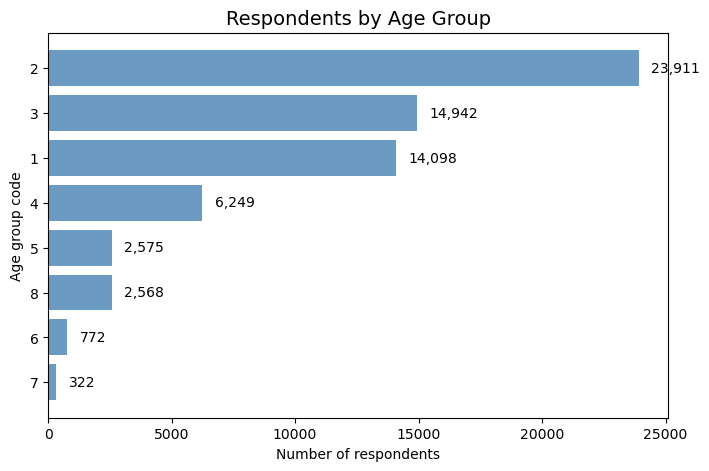

In [18]:
# Step 1.2 — Sort age groups by sample size and visualize the distribution

# 1️⃣ Count respondents per age group (descending order)
age_counts = (
    df['age']
    .value_counts()
    .rename_axis('age')
    .reset_index(name='count')
    .sort_values('count', ascending=False)
)
age_counts['pct'] = (age_counts['count'] / len(df) * 100).round(2)

# 2️⃣ Display the table
print("📊 Age group distribution (sorted by sample size):")
display(age_counts)

# 3️⃣ Show mapping if 'age_label' column exists
if 'age_label' in df.columns:
    age_labels = df[['age', 'age_label']].drop_duplicates().sort_values('age')
    print("\n🧩 Age group code → corresponding age range:")
    display(age_labels)
else:
    print("\n⚠️ No 'age_label' column found — only numeric codes available.")

# 4️⃣ Visualization — horizontal bar chart
plt.figure(figsize=(8,5))
plt.barh(
    age_counts['age'].astype(str),
    age_counts['count'],
    color='steelblue',
    alpha=0.8
)
plt.gca().invert_yaxis()  # Show largest group on top
plt.title("Respondents by Age Group", fontsize=14)
plt.xlabel("Number of respondents")
plt.ylabel("Age group code")

# Add count labels at the end of each bar
for i, v in enumerate(age_counts['count']):
    plt.text(v + 500, i, f"{v:,}", va='center', fontsize=10)

plt.show()

We can focus on the 18–44 age group (age codes 1–3) for our analysis. This group represents approximately 80% of the total sample, ensuring sufficient data for robust statistical insights. It also covers a complete life-cycle span, making it ideal for conducting stratified analyses on salary and perceptions of AI.

Remaining valid salary records: 22,765 (34.8% of total)


/var/folders/vk/wh57zgsj4dgdmfrh2qvbyyy80000gn/T/ipykernel_61954/3187130406.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


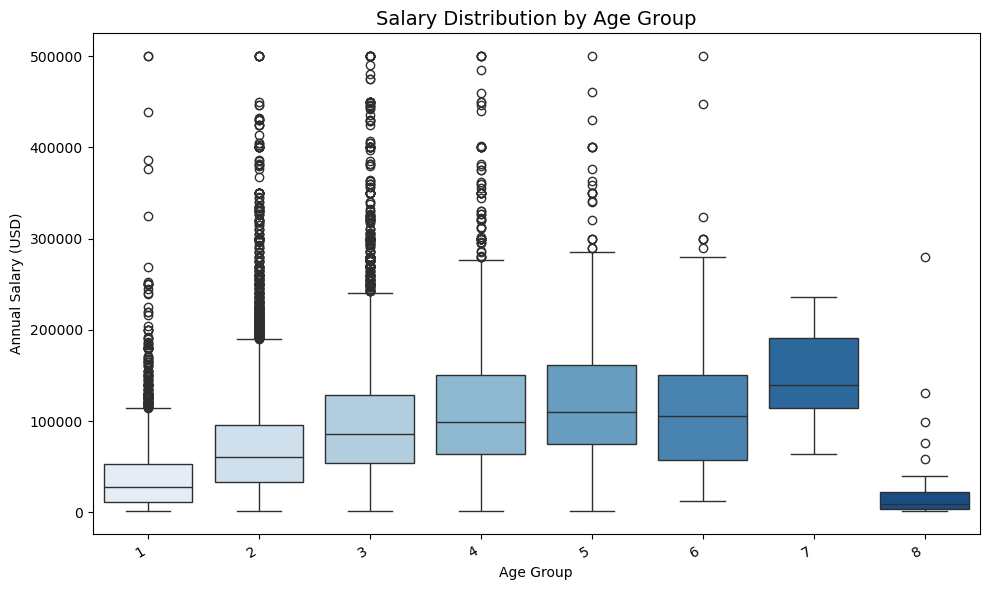

In [19]:
# Step 2.1 — Explore salary distribution across age groups

# 1️⃣ Keep only valid (non-null) salary values
df_salary = df.copy()
df_salary = df_salary[df_salary['converted_comp_yearly'].notna()]

# 2️⃣ Remove extreme outliers (e.g., below $1k or above $500k)
df_salary = df_salary[
    (df_salary['converted_comp_yearly'] >= 1000) &
    (df_salary['converted_comp_yearly'] <= 500000)
]

# 3️⃣ Check how many rows remain
print(f"Remaining valid salary records: {len(df_salary):,} ({len(df_salary)/len(df)*100:.1f}% of total)")

# 4️⃣ Merge readable age labels if available
if 'age_label' in df.columns:
    df_salary = df_salary.merge(
        df[['age', 'age_label']].drop_duplicates(),
        on='age',
        how='left'
    )
    age_col = 'age_label'
else:
    age_col = 'age'

# 5️⃣ Visualization — salary boxplot by age group
plt.figure(figsize=(10,6))
sns.boxplot(
    data=df_salary,
    x=age_col,
    y='converted_comp_yearly',
    palette='Blues',
)
plt.title("Salary Distribution by Age Group", fontsize=14)
plt.xlabel("Age Group")
plt.ylabel("Annual Salary (USD)")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()